Eventually this will be scripted up. Currently just drafting 

In [16]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import h5py

DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

TRAIN_MONTHS = pd.date_range(start='1981-01-01', end='2014-12-01', freq='MS')
VAL_MONTHS = pd.date_range(start='2015-01-01', end='2018-12-01', freq='MS')
TEST_MONTHS = pd.date_range(start='2019-01-01', end='2024-06-01', freq='MS')

def read_hdf5_file(data_path, data_name, load=True):
    with h5py.File(data_path, 'r') as f:
        return f[data_name][()]

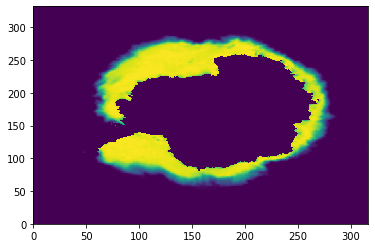

In [24]:
test = read_hdf5_file(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/targets.h5", "targets_sea_ice_only")
plt.pcolormesh(test[200,0,:,:])

In [34]:
def calculate_mse(x_true, x_pred): 
    if x_true.shape != x_pred.shape:
        raise ValueError(f"Inputs must be the same shape! {x_true.shape}, {x_pred.shape}")
    
    return np.mean((x_true - x_pred) ** 2)



In [35]:
first_range = pd.date_range('1981-01', pd.Timestamp('1987-12') - pd.DateOffset(months=6+1), freq='MS')
second_range = pd.date_range(pd.Timestamp('1988-01') + pd.DateOffset(months=12+1), '2024-01', freq='MS')
start_prediction_months = first_range.append(second_range)

targets = np.load(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/targets_all.npy")
linear_forecast = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/linear_forecasts/linear_forecast_all_years.nc").siconc

mse = np.zeros(start_prediction_months.shape)

split_array = np.empty(np.shape(start_prediction_months), dtype=object)
for i,month in enumerate(start_prediction_months):
    months = pd.date_range(month, month + pd.DateOffset(months=5), freq="MS")

    if month in TRAIN_MONTHS: 
        split_array[i] = "train"
    if month in VAL_MONTHS: 
        split_array[i] = "val"
    if month in TEST_MONTHS: 
        split_array[i] = "test"

    # calculate MSE  
    x_pred = np.transpose(linear_forecast.sel(time=months).values, (1, 2, 0))
    mse[i] = calculate_mse(targets[i,:,:,:], x_pred)


In [44]:
print(f"MSE of linear forecast for train months: {mse[split_array=='train'].mean()}")
print(f"MSE of linear forecast for val months: {mse[split_array=='val'].mean()}")
print(f"MSE of linear forecast for test months: {mse[split_array=='test'].mean()}")

MSE of linear forecast for train months: 1.3630801630110743
MSE of linear forecast for val months: 1.3628837346957372
MSE of linear forecast for test months: 1.3618720628693635


In [59]:
inputs_test = np.load(f"{DATA_DIRECTORY}/sicpred/data_pairs_npy/inputs_sea_ice_only.npy")


In [60]:
inputs_test.shape

(497, 332, 316, 14)